<font size="5">**Cross validating the premodel**</font>
<br /><br />
<font size="3">All the timings and accuracy values are taken from the <font color = "green">database</font>. The average premodel feature extraction and prediction time were calculated <font color = "green">separately</font> and added to premodel inference time.</font>
 

<font size="3">First, we import the necessary libraries and start the *image generator* class.</font>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn import preprocessing, neighbors
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
import premodel
#!pip install --user imblearn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_fscore_support
import image_generator
import database

In [2]:
image_generator.main()
imgGen = image_generator.ImageGenerator('images/val/images', 'images/val/val.txt', 'images/val/synset_words.txt')
label_list = imgGen.get_label_list()

images/val/images\ILSVRC2012_val_00023902.JPEG American alligator, Alligator mississipiensis
images/val/images\ILSVRC2012_val_00022100.JPEG worm fence, snake fence, snake-rail fence, Virginia fence
images/val/images\ILSVRC2012_val_00006920.JPEG EntleBucher
images/val/images\ILSVRC2012_val_00048551.JPEG snowmobile
images/val/images\ILSVRC2012_val_00033690.JPEG EntleBucher
images/val/images\ILSVRC2012_val_00031331.JPEG organ, pipe organ
images/val/images\ILSVRC2012_val_00029319.JPEG assault rifle, assault gun
images/val/images\ILSVRC2012_val_00023846.JPEG Eskimo dog, husky
images/val/images\ILSVRC2012_val_00000986.JPEG wolf spider, hunting spider
images/val/images\ILSVRC2012_val_00038277.JPEG geyser


<font size="5">**Running the premodel**</font>
<br /><br />
<font size="3">We cross validate two premodels (<font color = "green">logistic regression</font> and <font color = "green">knn</font>) with <font color = "green">10-fold cross validation</font> on <font color = "green">20k</font> images. So, we obtain the <u>predicted models</u> for all <font color = "green">20k</font> images.</font>

In [3]:
preference = 'Top-1'                # here, we select our preference, Top-1 or Top-5
n = 1                          # 1 for top-1, 5 for top-5
pre_model = premodel.Premodel(preference)

In [4]:
output_log_reg = pre_model.prototype(20000, ([('log_reg', 'log_reg', 'log_reg')]))  # logistic regression premodel

In [5]:
output_knn = pre_model.prototype(20000, ([('nn', 'nn', 'nn')]))      # knn premodel

<font size="5">**Testing the accuracy of the premodel**</font>
<br /><br />
<font size="3">First, we extract the predicted models for the 20k images for both <font color = "green">logistic regression</font> and <font color = "green">knn</font> premodels.</font>

In [6]:
def img_num_from_name(img_name):          # obtaining the image number from image name
    ext = []
    for i in range(len(img_name)):
        if i > 14 and i < 23:
            ext.append(img_name[i])
    j = 0
    for i in range(len(ext)):
        if ext[i] == '0':
            j = j + 1
        if ext[i] != '0':
            break
    rightNum = []
    for i in range(j, len(ext)):
        rightNum.append(ext[i])
    rightNum = ''.join(rightNum)
    rightNum = int(rightNum)
    return rightNum


predicted_models_log_reg = []                              # models predicted by logistic regression premodel
for i in range(10):
    for j in range(len(output_log_reg[5][i][1][0])):
        img_paths = (output_log_reg[5][i][1][0][j][0])
        img_nums = (img_num_from_name(img_paths))
        if output_log_reg[5][i][1][0][j][4] == 'tf-mobilenet_v1' and output_log_reg[5][i][1][0][j][3] == 1:
            predicted_models_log_reg.append([img_nums, 'mobilenet_v1'])
        elif output_log_reg[5][i][1][0][j][4] == 'tf-inception_v4' and output_log_reg[5][i][1][0][j][3] == 2:
            predicted_models_log_reg.append([img_nums, 'inception_v4'])
        elif output_log_reg[5][i][1][0][j][4] == 'tf-resnet_v1_152' and output_log_reg[5][i][1][0][j][3] == 3:
            predicted_models_log_reg.append([img_nums, 'resnet_v1_152'])
        elif output_log_reg[5][i][1][0][j][4] == 'failed':
            predicted_models_log_reg.append([img_nums, 'failed'])
        

predicted_models_knn = []                                    # models predicted by knn premodel            
for i in range(10):
    for j in range(len(output_knn[5][i][1][0])):
        img_paths = (output_knn[5][i][1][0][j][0])
        img_nums = (img_num_from_name(img_paths))
        if output_knn[5][i][1][0][j][4] == 'tf-mobilenet_v1' and output_knn[5][i][1][0][j][3] == 1:
            predicted_models_knn.append([img_nums, 'mobilenet_v1'])
        elif output_knn[5][i][1][0][j][4] == 'tf-inception_v4' and output_knn[5][i][1][0][j][3] == 2:
            predicted_models_knn.append([img_nums, 'inception_v4'])
        elif output_knn[5][i][1][0][j][4] == 'tf-resnet_v1_152' and output_knn[5][i][1][0][j][3] == 3:
            predicted_models_knn.append([img_nums, 'resnet_v1_152'])
        elif output_knn[5][i][1][0][j][4] == 'failed':
            predicted_models_knn.append([img_nums, 'failed'])

In [7]:
print(len(predicted_models_log_reg))

20000


In [8]:
print(len(predicted_models_knn))

20000


<font size="3">Now, we obtain the <font color = "green">accuracy</font> and <font color = "green">inference time</font> results of the predicted models from the database.</font>

In [9]:
accuracy_premodel = 0
time_premodel = 0
times = 0
log_reg_premodel_overhead = 42.39268                                      # average logistic regression premodel overhead

for i in range(len(predicted_models_log_reg)):
    if predicted_models_log_reg[i][1] != 'failed':
        times = times + 1                          # get_model_top_n (next line), where n is 1 or 5
        accuracy_premodel = accuracy_premodel + (database.get_model_top_n("inference", predicted_models_log_reg[i][0], predicted_models_log_reg[i][1], n))
        time_premodel = time_premodel + (database.get_model_time("inference", predicted_models_log_reg[i][0], predicted_models_log_reg[i][1]))

log_reg_accuracy = accuracy_premodel/len(predicted_models_log_reg)               # logistic regression premodel accuracy
log_reg_time = (time_premodel/times) + log_reg_premodel_overhead                 # logistic regression premodel inference time       
print("Logistic regression premodel accuracy = {}".format(log_reg_accuracy))
print("Logistic regression premodel average inference time = {}".format(log_reg_time))

Logistic regression premodel accuracy = 0.7667
Logistic regression premodel average inference time = 487.19725182873145


In [10]:
accuracy_premodel = 0
time_premodel = 0
times = 0
knn_premodel_overhead = 43.00882                                           # average knn premodel overhead

for i in range(len(predicted_models_knn)):
    if predicted_models_knn[i][1] != 'failed':
        times = times + 1                           # get_model_top_n (next line), where n is 1 or 5
        accuracy_premodel = accuracy_premodel + (database.get_model_top_n("inference", predicted_models_knn[i][0], predicted_models_knn[i][1], n))
        time_premodel = time_premodel + (database.get_model_time("inference", predicted_models_knn[i][0], predicted_models_knn[i][1]))

knn_accuracy = accuracy_premodel/len(predicted_models_knn)                        # knn premodel accuracy
knn_time = (time_premodel/times) + knn_premodel_overhead                             # knnn premodel inference time
print("KNN premodel accuracy = {}".format(knn_accuracy))
print("KNN premodel average inference time = {}".format(knn_time))

KNN premodel accuracy = 0.74845
KNN premodel average inference time = 481.9599984511785


<font size="5">**Comparing the results to MobileNet, Inception and ResNet**</font>
<br /><br />
<font size="3">We start by getting the <font color = "green">image numbers</font> of the 20k images.</font>

In [11]:
img_nums = []
for i in range(1, 20001):                        # the same range of images is selected
    img_nums.append(i)

<font size="3">Finally, we obtain the <font color = "green">accuracy</font> and <font color = "green">inference time</font> results for each DNN separately from the database.</font>

In [12]:
mobilenet_right = 0
mobilenet_time = 0
for i in range(len(img_nums)):                            # obtaining accuracy and inference time for each image
    mobilenet_right = mobilenet_right + (database.get_model_top_n("inference", img_nums[i], 'mobilenet_v1', n))
    mobilenet_time = mobilenet_time + (database.get_model_time("inference", img_nums[i], 'mobilenet_v1'))
print("Mobilenet top-{} accuracy = {}".format(n, mobilenet_right/len(img_nums)))          # accuracy over 20k images
print("Mobilenet average inference time = {}".format(mobilenet_time/len(img_nums)))   # average inference time over 20k images

inception_right = 0
inception_time = 0
for i in range(len(img_nums)):
    inception_right = inception_right + (database.get_model_top_n("inference", img_nums[i], 'inception_v4', n))
    inception_time = inception_time + (database.get_model_time("inference", img_nums[i], 'inception_v4'))
print("Inception top-{} accuracy = {}".format(n, inception_right/len(img_nums)))
print("Inception average inference time = {}".format(inception_time/len(img_nums)))

resnet_right = 0
resnet_time = 0
for i in range(len(img_nums)):
    resnet_right = resnet_right + (database.get_model_top_n("inference", img_nums[i], 'resnet_v1_152', n))
    resnet_time = resnet_time + (database.get_model_time("inference", img_nums[i], 'resnet_v1_152'))
print("ResNet top-{} accuracy = {}".format(n, resnet_right/len(img_nums)))
print("ResNet average inference time = {}".format(resnet_time/len(img_nums)))

Mobilenet top-1 accuracy = 0.71375
Mobilenet average inference time = 103.11685
Inception top-1 accuracy = 0.7995
Inception average inference time = 685.91255
ResNet top-1 accuracy = 0.7665
ResNet average inference time = 734.5622


<font size="3">Here, we plot the results for comparison.</font>

In [13]:
import matplotlib.pyplot as plt

No handles with labels found to put in legend.


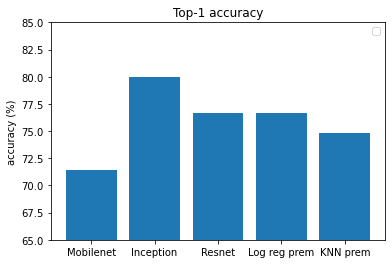

In [17]:
model_names = ['Mobilenet', 'Inception', 'Resnet', 'Log reg prem', 'KNN prem']
accuracy = [mobilenet_right/len(img_nums), inception_right/len(img_nums),
            resnet_right/len(img_nums), log_reg_accuracy, knn_accuracy]

for i in range(len(accuracy)):
    accuracy[i] = accuracy[i]*100

ypos = np.arange(len(model_names))

plt.xticks(ypos, model_names)
plt.ylabel("accuracy (%)")
plt.title("{} accuracy".format(preference))
plt.bar(ypos, accuracy)
plt.ylim(top = 85)
plt.ylim(bottom = 65)
plt.legend()

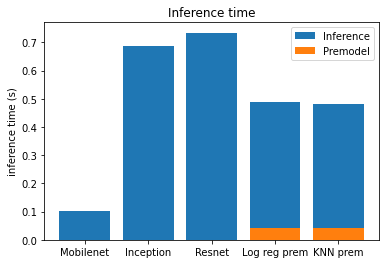

In [15]:
times = [mobilenet_time/len(img_nums), inception_time/len(img_nums),
         resnet_time/len(img_nums), log_reg_time, knn_time]
times_premodel = [0, 0, 0, log_reg_premodel_overhead, knn_premodel_overhead]

for i in range(len(times)):
    times[i] = times[i]/1000

for i in range(len(times_premodel)):
    times_premodel[i] = times_premodel[i]/1000
    
plt.xticks(ypos, model_names)
plt.ylabel("inference time (s)")
plt.title("Inference time")
plt.bar(ypos, times, label = "Inference")
plt.bar(ypos, times_premodel, label = "Premodel")
plt.legend()